In [1]:
import cv2
import numpy as np
import pandas as pd
import os 
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern

In [2]:
def pixel_calculator(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except IndexError as error:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):   
    center = img[x][y]
    val_ar = []
    val_ar.append(pixel_calculator(img, center, x-1, y+1))     # top_right
    val_ar.append(pixel_calculator(img, center, x, y+1))       # right
    val_ar.append(pixel_calculator(img, center, x+1, y+1))     # bottom_right
    val_ar.append(pixel_calculator(img, center, x+1, y))       # bottom
    val_ar.append(pixel_calculator(img, center, x+1, y-1))     # bottom_left
    val_ar.append(pixel_calculator(img, center, x, y-1))       # left
    val_ar.append(pixel_calculator(img, center, x-1, y-1))     # top_left
    val_ar.append(pixel_calculator(img, center, x-1, y))       # top
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

def lbp_hist_calculator(file_path):
    """

    Parameters
    ----------
    file_path : str
        Image file path

    Returns
    -------
    hist_lbp : Vector (256 by 1)
        Local binary features' histogram

    """
    img_bgr = cv2.imread(file_path)
    height, width, channel = img_bgr.shape
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp

In [3]:
from feature_extraction.orb import ORB
import os
import cv2
from matplotlib import pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

DATA_PATH="C:\\Users\\krgza\\Desktop\\Master Dersler\\cmpE 537 Computer Vision\\HW3\\Caltech20"
TRAINING_DIR=os.path.join(DATA_PATH, "training")
TEST_DIR=os.path.join(DATA_PATH, "testing")
classes = []
features = {}
all_descriptor = []

for class_name in sorted(os.listdir(TRAINING_DIR)):
    classes.append(class_name)
    features[class_name] = {}
    class_dir = os.path.join(TRAINING_DIR, class_name)
    for file_name in sorted(os.listdir(class_dir)):
        filename = os.path.join(class_dir, file_name)
        des = lbp_hist_calculator(filename)   
        if des is not None:
            des = des[:32]
            features[class_name][file_name] = des
            all_descriptor.extend(des)

In [12]:
kmeans = KMeans(100) #20,100
kmeans.fit(all_descriptor)
centers = kmeans.cluster_centers_

In [13]:
from feature_quantization.bag_of_visual_words import get_histogram #Mahmut's implementation

histograms = {}
X = []
Y = []
for c_name in features:
    histograms[c_name] = []
    for img in features[c_name]:
        histograms[c_name].append(get_histogram(features[c_name][img], centers))
        
for c in histograms:
    X.extend(histograms[c])
    Y.extend([c] * len(histograms[c]))

                  precision    recall  f1-score   support

           Faces       0.31      0.85      0.45        20
       airplanes       0.11      0.75      0.19        20
          anchor       0.00      0.00      0.00        20
background_class       0.00      1.00      0.00         0
          barrel       0.00      0.00      0.00        20
          camera       0.10      0.05      0.07        20
        car_side       0.14      0.05      0.07        20
       dalmatian       1.00      0.00      0.00        20
           ferry       0.00      0.00      0.00        20
       headphone       0.00      0.00      0.00        20
            lamp       1.00      0.00      0.00        20
           pizza       0.08      0.05      0.06        20
         pyramid       0.20      0.05      0.08        20
          snoopy       0.00      0.00      0.00        20
     soccer_ball       0.00      1.00      0.00         0
       stop_sign       1.00      0.00      0.00        20
      strawbe

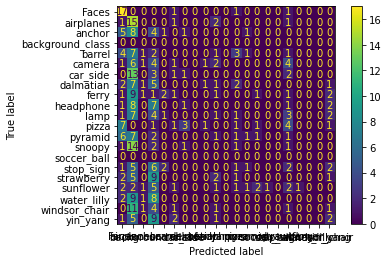

In [14]:
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

test_classes = []
test_features = {}
testX = []
testY = []

classifier = AdaBoostClassifier(n_estimators=400, random_state=0)
le = preprocessing.LabelEncoder()
training_labels_encoded = le.fit_transform(Y)

for class_name in sorted(os.listdir(TEST_DIR)):
    class_dir = os.path.join(TEST_DIR, class_name)
    for file_name in sorted(os.listdir(class_dir)):
        filename = os.path.join(class_dir, file_name)
        des = lbp_hist_calculator(filename)
        if des is not None:
            des = des[:32]
            histogram = get_histogram(des, centers)
            testX.append(histogram)
            testY.append(class_name)


testing_labels_encoded = le.transform(testY)
class_encode_match = le.get_params()
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
classifier.fit(X, training_labels_encoded)
predictions = classifier.predict(testX)
target_names = keys
print(classification_report(testing_labels_encoded, predictions, target_names=keys,zero_division=1))
cm = confusion_matrix(testing_labels_encoded, predictions, labels=values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = keys)
disp.plot()
plt.show()

                  precision    recall  f1-score   support

           Faces       0.78      0.35      0.48        20
       airplanes       0.08      0.25      0.12        20
          anchor       0.12      0.05      0.07        20
background_class       0.00      1.00      0.00         0
          barrel       0.00      0.00      0.00        20
          camera       0.21      0.30      0.25        20
        car_side       0.22      0.40      0.29        20
       dalmatian       0.00      0.00      0.00        20
           ferry       0.00      0.00      0.00        20
       headphone       0.00      0.00      0.00        20
            lamp       0.00      0.00      0.00        20
           pizza       0.00      0.00      0.00        20
         pyramid       0.10      0.45      0.17        20
          snoopy       0.17      0.20      0.18        20
     soccer_ball       0.00      1.00      0.00         0
       stop_sign       0.00      0.00      0.00        20
      strawbe

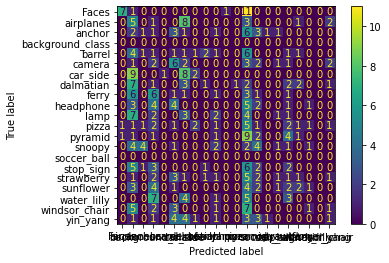